In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
from sklearn.preprocessing import LabelEncoder
from catboost import CatBoostClassifier
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score，confusion_matrix

In [40]:
from functions import helpers
from functions import models
from functions import classifiers
from functions import metric

In [3]:
df_mice = pd.read_csv('../data/data_mice.csv')
df_mice = df_mice[df_mice['Csection.Urgency'] != 'Schedule']
del df_mice['Method.of.Delivery.A']
del df_mice['Csection.Incidence'] 

In [4]:
df_mice

,Age,Gravida,Para,Number.of.Babies.In.Womb,Delivery.Year,Infant.Cord.Vessels.A,Infant.Length.A,Birthweight.A,GA.At.Birth.A,Weight.Prepregnancy,...,reason_for_admission_ROM,reason_for_admission_Observe,reason_for_admission_other,race_black,race_white,race_pacific_islander,race_asian,race_arabic,race_american_indian,race_other
0,24,2,1,1,2019,3,21.00,3590,39.1,248,...,False,False,False,False,True,False,False,False,False,False
1,26,4,2,1,2019,3,18.75,2880,37.5,195,...,False,False,False,False,True,False,False,False,False,False
2,21,1,0,1,2019,3,20.00,2830,39.1,135,...,False,False,False,False,True,False,False,False,False,False
3,31,1,0,1,2019,3,20.25,3730,39.3,130,...,False,False,False,False,True,False,False,False,False,False
4,23,6,1,1,2019,3,17.00,2150,32.4,138,...,False,False,False,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17613,27,1,0,1,2023,3,19.75,3290,39.3,187,...,False,False,False,False,True,False,False,False,False,False
17616,23,2,1,1,2023,3,21.00,3700,40.3,110,...,False,False,False,False,True,False,False,False,False,False
17617,25,1,1,1,2023,3,20.00,2710,39.3,231,...,True,False,False,False,True,False,False,False,False,False
17618,34,1,0,1,2023,3,19.75,3160,39.0,138,...,False,False,False,False,True,False,False,False,False,False


In [5]:
urgency_mice = df_mice.pop('Csection.Urgency')

In [6]:
labels_mice=LabelEncoder().fit_transform(urgency_mice)
print(Counter(labels_mice))

Counter({1: 12334, 2: 2572, 0: 500})


In [7]:
df_mice.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15406 entries, 0 to 17619
Data columns (total 90 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Age                              15406 non-null  int64  
 1   Gravida                          15406 non-null  int64  
 2   Para                             15406 non-null  int64  
 3   Number.of.Babies.In.Womb         15406 non-null  int64  
 4   Delivery.Year                    15406 non-null  int64  
 5   Infant.Cord.Vessels.A            15406 non-null  int64  
 6   Infant.Length.A                  15406 non-null  float64
 7   Birthweight.A                    15406 non-null  int64  
 8   GA.At.Birth.A                    15406 non-null  float64
 9   Weight.Prepregnancy              15406 non-null  int64  
 10  Weight.Gain.Pounds               15406 non-null  int64  
 11  OFC.At.Birth.Baby.A.In           15406 non-null  float64
 12  Quantitative.Blood.Loss

###  Model ( RF / CatBoost)

In [8]:
features = pd.get_dummies(df_mice)

In [9]:
X_train, X_test, y_train, y_test = helpers.split_and_scale_data(features, labels_mice)

In [10]:
print(X_train.shape,X_test.shape)

(10784, 234) (4622, 234)


In [11]:
print(Counter(y_train))

Counter({1: 8608, 2: 1815, 0: 361})


In [12]:
print(Counter(y_test))

Counter({1: 3726, 2: 757, 0: 139})


In [13]:
X_train, y_train = helpers.perform_SMOTE(X_train, y_train)
print(Counter(y_train))

Counter({1: 8608, 2: 8608, 0: 8608})


In [14]:
y_test

array([1, 1, 1, ..., 1, 1, 1])

#### LASSO

#### RF

In [15]:
y_pred_binary2, y_pred2 = classifiers.run_RF(X_train, X_test, y_train, y_test, label='Urgent Csection')

Building model for label: Urgent Csection


/lustre/isaac/scratch/mhe8/medenv/lib/python3.11/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Predicting on test data for label: Urgent Csection


In [16]:
print(Counter(y_test))

Counter({1: 3726, 2: 757, 0: 139})


In [17]:
print(Counter(y_pred_binary2))

Counter({1: 2156, 0: 2076, 2: 390})


In [21]:
confusion_matrix(y_test,y_pred_binary2)

array([[ 120,    3,   16],
       [1513, 2151,   62],
       [ 443,    2,  312]])

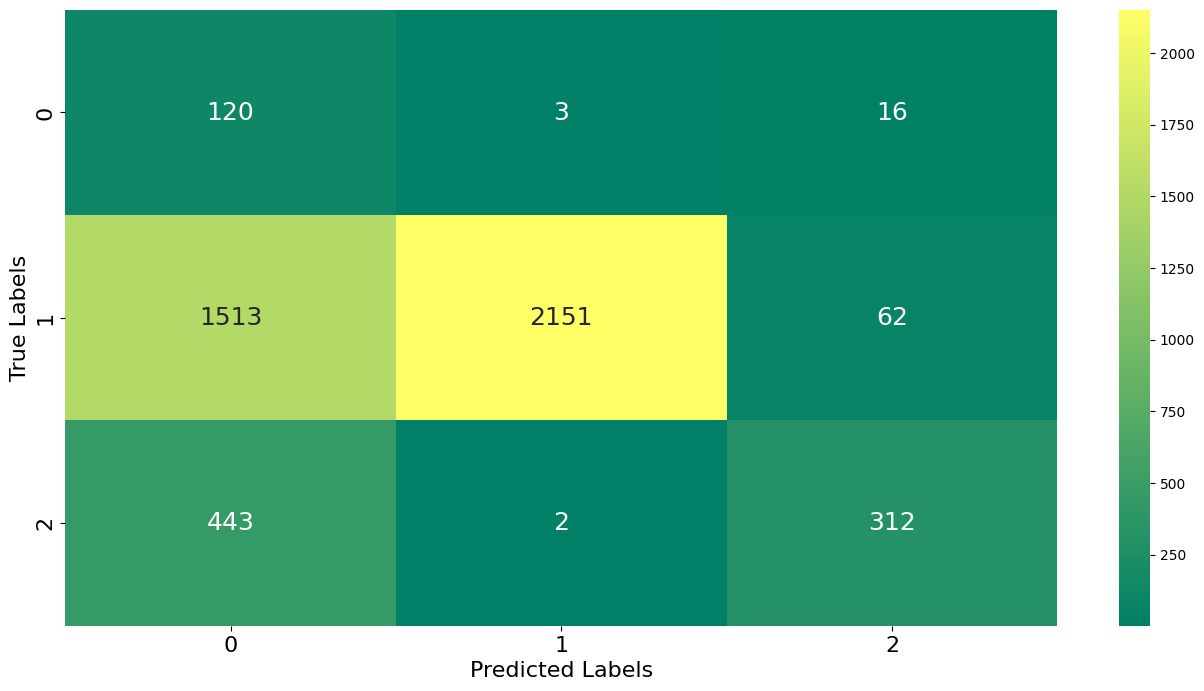

In [22]:
metric.confusion_matrix2(y_test,y_pred_binary2)

In [23]:
print('AUC:', metric.roc_auc_score_multiclass(y_test, y_pred_binary2))
print('Accuracy:', metric.accuracy(y_test, y_pred_binary2))
print('Precision:', metric.macro_precision(y_test, y_pred_binary2))
print('Recall:', metric.macro_recall(y_test, y_pred_binary2))
print('F1:', metric.macro_f1(y_test, y_pred_binary2))

AUC: {0: 0.7134971924311989, 1: 0.7858571644237405, 2: 0.6959860619555985}
Accuracy: 0.5588489831241886
Precision: 0.618494785401418
Recall: 0.6175857560192605
F1: 0.46125429808463814


In [25]:
print('Specific Recall for emergency C-Section:', metric.specific_recall(y_test, y_pred_binary2,specific_class=0))

Specific Recall for emergency C-Section: 0.863309346307127


In [44]:
def specific_precision(y_true, y_pred,specific_class):# calculate the recall  for class 0


    # all classes except specific_class are considered negative
    temp_true = [1 if p == specific_class else 0 for p in y_true]
    temp_pred = [1 if p == specific_class else 0 for p in y_pred]
    
    
    # compute true positive for specific_class 
    tp = metric.true_positive(temp_true, temp_pred)
    
    # compute false negative for specific_class 
    fp = metric.false_positive(temp_true, temp_pred)
    
    
    # compute recall for specific_class
    precision = tp / (tp + fp)
    
    return precision

In [45]:
print('Specific precision for emergency C-Section:', specific_precision(y_test, y_pred_binary2,specific_class=0))

Specific precision for emergency C-Section: 0.057803468208092484


#### CatBoost 

In [27]:
from catboost import CatBoostClassifier
# Create CatBoost classifier
random.seed(1992)
clf = CatBoostClassifier(iterations=100, learning_rate=0.1, depth=6)

# Fit the classifier to the training data
clf.fit(X_train, y_train, verbose=10)

TBB Warning: The number of workers is currently limited to 0. The request for 47 workers is ignored. Further requests for more workers will be silently ignored until the limit changes.



0:	learn: 0.9879661	total: 220ms	remaining: 21.8s
10:	learn: 0.5541804	total: 1.55s	remaining: 12.6s
20:	learn: 0.4283746	total: 2.85s	remaining: 10.7s
30:	learn: 0.3621965	total: 4.13s	remaining: 9.2s
40:	learn: 0.3233442	total: 5.43s	remaining: 7.82s
50:	learn: 0.2951688	total: 6.71s	remaining: 6.44s
60:	learn: 0.2727461	total: 7.95s	remaining: 5.08s
70:	learn: 0.2552463	total: 9.2s	remaining: 3.76s
80:	learn: 0.2419520	total: 10.5s	remaining: 2.45s
90:	learn: 0.2274287	total: 11.7s	remaining: 1.16s
99:	learn: 0.2174577	total: 12.9s	remaining: 0us


In [28]:
# Make predictions on the testing data
y_pred_prob = clf.predict_proba(X_test)

In [29]:
y_pred = clf.predict(X_test)

In [30]:
y_pred

array([[1],
       [1],
       [1],
       ...,
       [1],
       [1],
       [1]])

In [ ]:
#y_pred_prob_0 = y_pred_prob[:,0]

In [ ]:
#y_pred_prob_0

In [35]:
confusion_matrix(y_test,y_pred)

array([[  83,    9,   47],
       [  50, 3496,  180],
       [  65,   30,  662]])

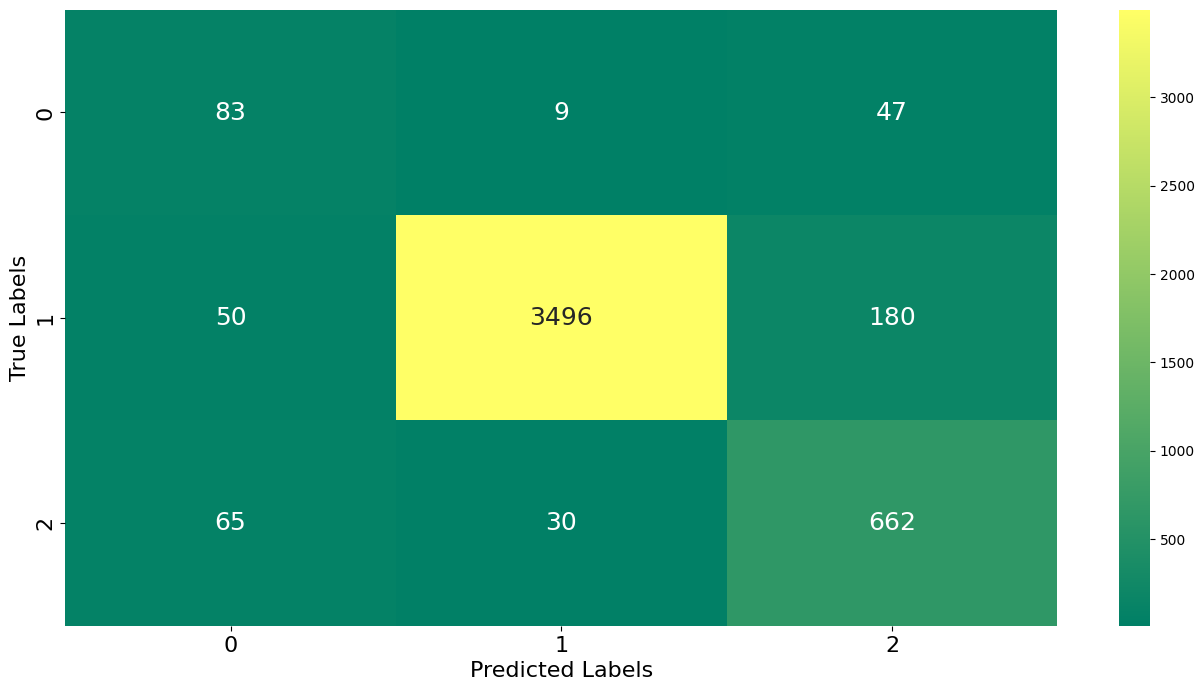

In [34]:
metric.confusion_matrix2(y_test,y_pred)

In [36]:
print('AUC:', metric.roc_auc_score_multiclass(y_test, y_pred))
print('Accuracy:', metric.accuracy(y_test, y_pred))
print('Precision:', metric.macro_precision(y_test, y_pred))
print('Recall:', metric.macro_recall(y_test, y_pred))
print('F1:', metric.macro_f1(y_test, y_pred))

AUC: {0: 0.7857349186454985, 1: 0.9473724096119929, 2: 0.9078862056767283}
Accuracy: 0.9175681523150151
Precision: 0.7176054340060144
Recall: 0.80329950830251
F1: 0.7533023730022977


In [47]:
print('Specific Recall for emergency C-Section:', metric.specific_recall(y_test, y_pred,specific_class=0))
print('Specific Precision for emergency C-Section:', metric.specific_precision(y_test, y_pred,specific_class=0))

Specific Recall for emergency C-Section: 0.5971222978624295


###  Model (AE +LASSO / RF/ CatBoost)

In [39]:
AE_train, AE_test = models.run_AE(X_train, X_test)

ValueError: Invalid parameter activation for estimator KerasClassifier.
This issue can likely be resolved by setting this parameter in the KerasClassifier constructor:
`KerasClassifier(activation=relu)`
Check the list of available parameters with `estimator.get_params().keys()`

#### RF

In [ ]:
y_pred_AErf, y_pred_prob_AE = classifiers.run_RF(AE_train, AE_test, y_train, y_test, label='Urgent Csection')

In [ ]:
confusion_matrix2(y_test,y_pred_AErf)

In [ ]:
print('AUC:', metric.roc_auc_score_multiclass(y_test, y_pred_AErf))
print('Accuracy:', metric.accuracy(y_test, y_pred_AErf))

In [ ]:
print('Precision:', metric.macro_precision(y_test, y_pred_AErf))
print('Recall:', metric.macro_recall(y_test, y_pred_AErf))
print('F1:', metric.macro_f1(y_test, y_pred_AErf))

In [ ]:
print('Specific Recall for emergency C-Section:', metric.specific_recall(y_test, y_pred_AErf,specific_class=0))

#### CatBoost

In [ ]:
## AE+catboost (very fast, because no grid search?)
clf_AE = CatBoostClassifier(iterations=100, learning_rate=0.1, depth=6)
# Fit the classifier to the training data
clf_AE.fit(AE_train, y_train, verbose=10)

In [ ]:
# Make predictions on the testing data
y_pred_prob_AEcat = clf_AE.predict_proba(AE_test)
y_pred_AEcat = clf_AE.predict(AE_test)

In [ ]:
confusion_matrix2(y_test,y_pred_AEcat)

In [ ]:
print('AUC:', metric.roc_auc_score_multiclass(y_test, y_pred_AEcat))
print('Accuracy:', metric.accuracy(y_test, y_pred_AEcat))

In [ ]:
print('Precision:', metric.macro_precision(y_test, y_pred_AEcat))
print('Recall:',metric.macro_recall(y_test, y_pred_AEcat))
print('F1:', metric.macro_f1(y_test, y_pred_AEcat))

In [ ]:
print('Specific Recall for emergency C-Section:', metric.specific_recall(y_test, y_pred_AEcat,specific_class=0))

### Deep Neural Network Model

In [ ]:
labels_mice

In [ ]:
y_onehot = to_categorical(labels_mice, num_classes=3) 

In [ ]:
y_onehot

In [ ]:
X_train_nn, X_test_nn, y_train_nn, y_test_nn = helpers.split_and_scale_data(features, y_onehot)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from sklearn.datasets import make_classification

In [ ]:
# Build the DNN model
model_nn = Sequential()
model_nn.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model_nn.add(Dense(32, activation='relu'))
model_nn.add(Dense(16, activation='relu'))
model_nn.add(Dense(3, activation='softmax'))  # 3 output classes

In [ ]:
# Compile the model
model_nn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the model
history = model_nn.fit(X_train_nn, y_train_nn, epochs=50, batch_size=32, validation_split=0.2)


In [ ]:

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy:.4f}')


In [ ]:
# Make predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)